In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data, wb
import scipy.optimize as sco
import scipy.interpolate as itp

In [2]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
symbols = ['GOGL', 'BABA']
noa = len(symbols)

In [4]:
from datetime import datetime, timedelta
N = 200
days_ago_N = datetime.now() - timedelta(days=N)
days_ago_N_string = days_ago_N.strftime('%Y-%m-%d')

In [5]:
%%time
df = pd.DataFrame()
start = days_ago_N_string
for symbol in symbols:
    print(symbol)
    df[symbol] = data.DataReader(symbol, 'google', start)['Close']

GOGL
BABA
CPU times: user 107 ms, sys: 12.5 ms, total: 120 ms
Wall time: 888 ms


In [6]:
df.head()

,GOGL,BABA
Date,,
2017-01-30,5.55,101.02
2017-01-31,5.46,101.31
2017-02-01,5.65,101.57
2017-02-02,5.54,100.84
2017-02-03,5.52,100.39


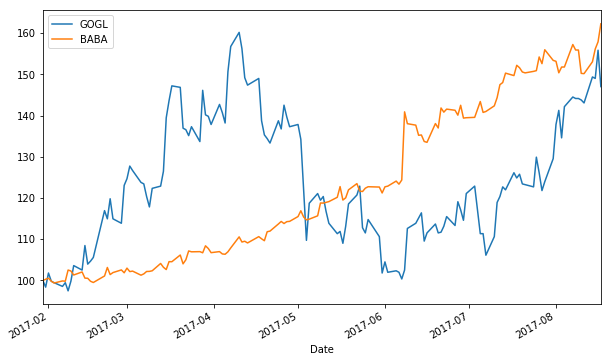

In [7]:
(df / df.ix[0] * 100).plot(figsize=(10,6))

In [8]:
rets = np.log(df / df.shift(1))

In [9]:
rets.mean() * 252

GOGL    0.698795
BABA    0.877576
dtype: float64

In [10]:
rets.cov() * 252

,GOGL,BABA
GOGL,0.375193,0.005604
BABA,0.005604,0.067632


In [11]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.54621743,  0.45378257])

In [12]:
np.dot(weights.T, rets.mean()) * 252

0.77992266913808228

In [13]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.12864520481816064

In [14]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.35867144410750157

In [15]:
prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights = weights / np.sum(weights)
    prets.append(np.dot(weights.T, rets.mean() * 252))
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
    
prets = np.array(prets)
pvols = np.array(pvols)

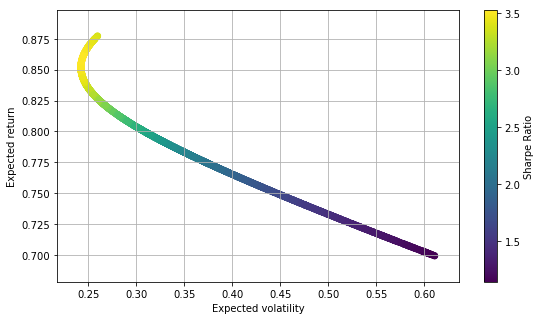

In [16]:
plt.figure(figsize=(9, 5))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe Ratio')

In [17]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.dot(weights.T, rets.mean() * 252)
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [18]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [19]:
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(noa))

In [20]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

CPU times: user 47.2 ms, sys: 1.29 ms, total: 48.5 ms
Wall time: 75.2 ms


In [21]:
opts

     fun: -3.5260702233408847
     jac: array([ 0.00285587, -0.00037214,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 20
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([ 0.11528622,  0.88471378])

In [22]:
def calc_weights(BP, xs, df):
    t = BP / np.dot(df.tail(1), xs)
    print t * xs
    print symbols

In [23]:
calc_weights(213, opts.x, df)

[ 0.16823415  1.29103959]
['GOGL', 'BABA']
